# Guardians of the Memory - Baseline Model - Felix

Baseline model for the HHD classification problem. The task is to classify if a certain HDD will fail in the next x days (in the following we try to predict HDD failure two weeks in advance).

As a metric, we look at the area under the ROC curve while we monitor the recall. We want to minimize false negatives (predicting that a HDD will not fail, but it fails nevertheless) as this might lead to data loss and maintenance downtime.

The dataset we use contains only the one model that failed the most recently (Seagate ST4000DM000) and only drives where we observed the failing in the dataset (2020 untill 2021). We use all available dates for those drives.

For the baseline model, we focus on the four most important features that we observed in the EDA: `smart_5_raw`, `smart_183_raw`, `smart_184_raw` and `smart_187_raw`. We calculate the median of those features a certain number of days before the drives fail use this value as threshold. If two (out of the four) of the features of a drive are above the threshold, we predict that the drive will fail in the given time window.

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import mlflow
# Setup MLFlow
EXPERIMENT_NAME = "guardians_of_the_memory_felix"
TRACKING_URI = open("../.mlflow_uri").read().strip()

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, fbeta_score

RSEED = 42

## Preprocessing

Load the data

In [2]:
df = pd.read_csv("../data/interim/ST4000DM000_history.csv", parse_dates=["date"]) # Full history
failure_dates = pd.read_csv("../data/interim/ST4000DM000_failure.csv", parse_dates=["date"]) # Failure dates

Merge the failure date

In [3]:
df = pd.merge(  left=df, right=failure_dates[["serial_number", "date"]],
                how="left", on="serial_number", suffixes=("", "_failure"),
                )
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw,date_failure
0,2020-09-15,Z304KBK4,ST4000DM000,4000787030016,0,113.0,53991680.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-16
1,2020-09-15,Z304JGH0,ST4000DM000,4000787030016,0,111.0,31142392.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-14
2,2020-09-15,Z302SYHL,ST4000DM000,4000787030016,0,120.0,238681648.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-22
3,2020-09-15,S3010L7K,ST4000DM000,4000787030016,0,118.0,180888736.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-11
4,2020-09-15,Z304JM6A,ST4000DM000,4000787030016,0,114.0,59625576.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-24


Calculate the days to fail and select all hdds that have a failure date

In [4]:
df["days_to_fail"] = (df.date_failure - df.date).dt.days # Days to fail as int
df_full = df.copy() # Backup
df = df[df.days_to_fail.notna()] # Select all HDDs with failure dates
df.shape

(243280, 181)

Drop cols with many missings

In [5]:
cols_to_drop = df.columns[df.notna().sum() < (0.8 * len(df))] # Columns that contain lot of NaNs
print("Number of columns to drop:", len(cols_to_drop))
df.drop(cols_to_drop, axis=1, inplace=True) # Drop the cols
print("Shape of the dataframe", df.shape)

Number of columns to drop: 126
Shape of the dataframe (243280, 55)


Drop unnecessary cols

In [6]:
cols_to_drop = ["model", "capacity_bytes", "failure", "date_failure"] # We don't care about them here
print("Number of columns to drop:", len(cols_to_drop))
df.drop(cols_to_drop, axis=1, inplace=True) # Drop the cols
print("Shape of the dataframe", df.shape)

Number of columns to drop: 4
Shape of the dataframe (243280, 51)


Drop cols with constant values (std=0)

In [7]:
mask = np.insert((df.std() == 0).to_numpy(),0,False) # Look std of column is 0
cols_to_drop = df.columns[mask]
print("Number of columns to drop:", len(cols_to_drop))
df.drop(cols_to_drop, axis=1, inplace=True) # Drop the cols
print("Shape of the dataframe", df.shape)

Number of columns to drop: 12
Shape of the dataframe (243280, 39)


Drop rows NaNs since we only have 19

In [8]:
print("Shape of the dataframe", df.shape)
print("Max number of NaN rows:", df.isna().sum().max())
df.dropna(inplace=True) # Drop observations with NaNs
print("Shape of the dataframe", df.shape)

Shape of the dataframe (243280, 39)
Max number of NaN rows: 19
Shape of the dataframe (243261, 39)


Kick out negative days to fail (repaired HDDs) - this probably needs mor thorough treatment (right now we select a random failure date from multiples, should probably only select the first one)

In [9]:
df = df.query("days_to_fail >= 0")
print("Shape of the dataframe", df.shape)

Shape of the dataframe (243179, 39)


## Statistics of our important features

In [10]:
feats_bl = ["smart_5_raw",
            "smart_183_raw",
            "smart_184_raw",
            "smart_187_raw",
            ]

df[feats_bl].describe().T

,count,mean,std,min,25%,50%,75%,max
smart_5_raw,243179.0,226.726420,2632.867959,0.0,0.0,0.0,0.0,65488.0
smart_183_raw,243179.0,5.062941,28.927995,0.0,0.0,0.0,2.0,720.0
smart_184_raw,243179.0,0.282738,5.545636,0.0,0.0,0.0,0.0,340.0
smart_187_raw,243179.0,9.311470,35.394915,0.0,0.0,0.0,4.0,940.0


Plots of features over time

We plot the median of the features over time to see if they change gradually towards failure

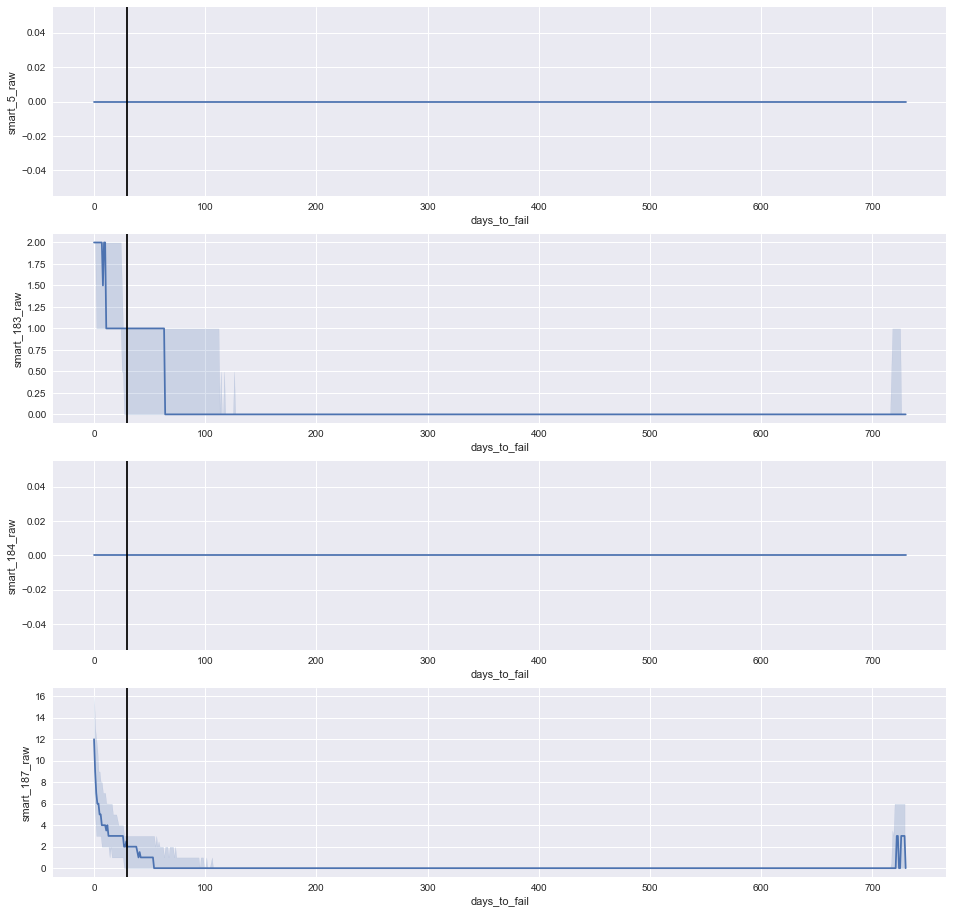

In [11]:
time_window = 30 # Line for plotting
plt.figure(figsize=(16,16))
for num, feat in enumerate(feats_bl):
    plt.subplot(4,1,num+1)
    sns.lineplot(x=df.days_to_fail, y=df[feat], estimator=np.median)
    plt.axvline(x=time_window, c='k')

`smart_183_raw` and `smart_187_raw` seem to be very good indicators. `smart_5_raw` and `smart_184_raw` are also good indicators (check mean plots), but only for a small fraction of HDDs.

Towards large values of days_to_fail, we observe some fluctuations. The come from the fact, that we have only very limited statistics available. The number of HDDs in the dataset decreases as a function of days_to_fail, since a rather constant fail rate "takes them out day by day". This can be seen in the following histogram.

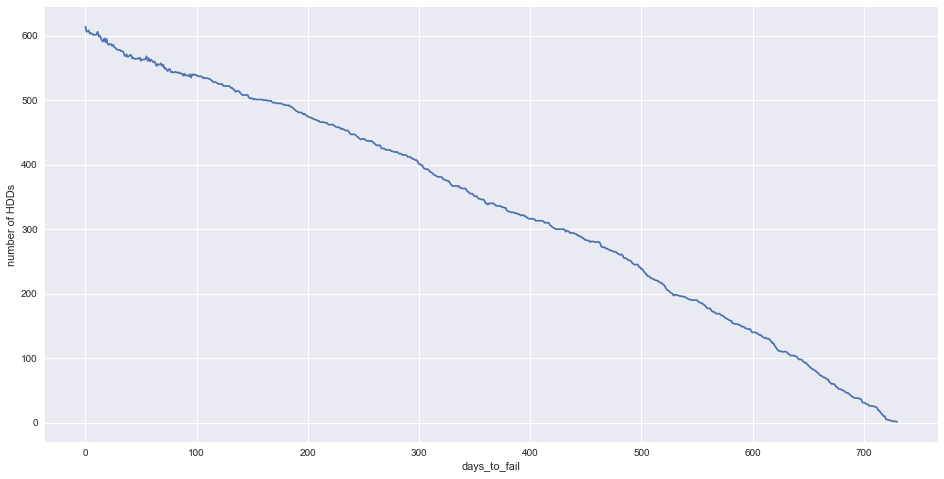

In [12]:
plt.figure(figsize=(16,8))
# sns.lineplot(x=df.groupby("days_to_fail").count().index, y=df.groupby("days_to_fail").count().date)
sns.lineplot(data=df.groupby("days_to_fail").count().date)
plt.ylabel("number of HDDs");

Next, we look at how the distribution of smart_5 evolves over time

<Figure size 1152x576 with 0 Axes>

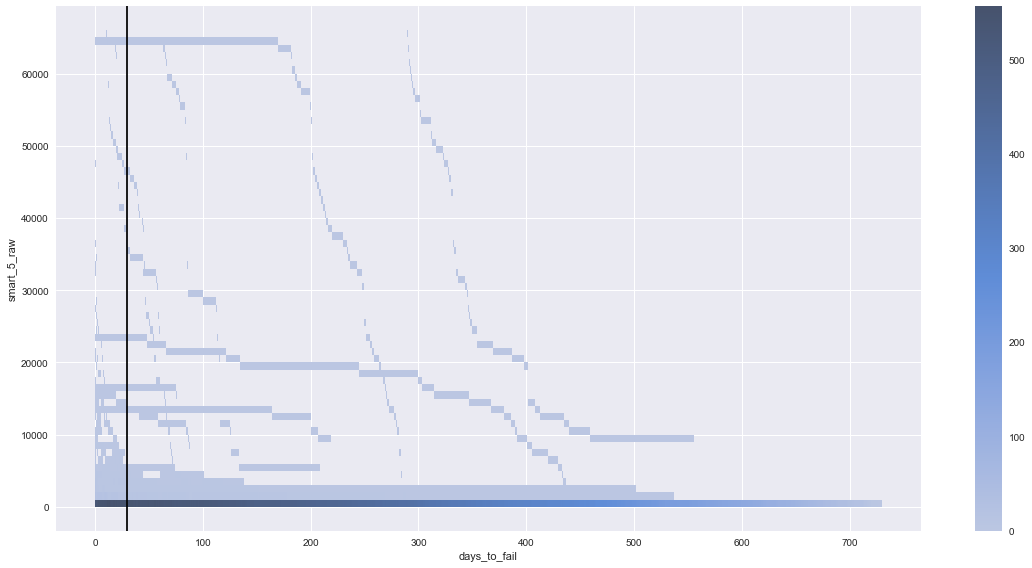

In [13]:
plt.figure(figsize=(16,8))
sns.displot(x=df.days_to_fail, y=df.smart_5_raw, binwidth=(1, 1000), cbar=True, height=8, aspect=2)
plt.axvline(x=time_window, c='k');

Most of the drives show a value of `0` all the time. Individual drives show an increase quite early without imminent failure. Those will be falsely classified by our baseline model, but their number is rather small.

## Baseline Model

### Train-test split

We have to split by drive serial numbers (all time data for one drive stays in one set). This cannot be done by stratify, so we write our own function.

In [14]:
drives = pd.Series(df.serial_number.unique(), name="HDD") # All the unique serial numbers
test_size = 0.3
time_window = 14
drives_test = drives.sample(int(test_size * len(drives)), random_state=RSEED) # Random sampling of drives
drives_train = drives.drop(drives_test.index, axis=0) # Remaining drives end up in the train set
df_train = df[df.serial_number.isin(drives_train)]
df_test = df[df.serial_number.isin(drives_test)]

Generate dataframes from the drive lists

In [15]:
X_train = df_train[feats_bl]
X_test = df_test[feats_bl]
print("Shape train set:", X_train.shape, "\nShape test set:", X_test.shape)

Shape train set: (169566, 4) 
Shape test set: (73613, 4)


Generate targets: `True` if `days_to_fail` is smaller than our time window, `False` otherwise.

In [16]:
y_train = df_train.days_to_fail <= time_window
y_test = df_test.days_to_fail <= time_window

Now we check if our sampling is stratified:

In [17]:
y_train.sum()/len(y_train), y_test.sum()/len(y_test)

(0.03756649328285151, 0.036433782076535394)

I would say it looks ok. Perhaps stratify can be included later.

Now lets setup MLFlow:

In [18]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

Active run_id: 358999b635af4ea08730a072fa68f47f


### Train the baseline model

Therefore we have to calculate the thresholds.

In [19]:
threshold = pd.Series(name="Threshold")
# Dataframe with all train drives exactly time_window days before failure
df_time_window = df[df.serial_number.isin(drives_train)].query("days_to_fail ==@ time_window")
for feat in feats_bl:
    threshold[feat] = df_time_window[feat].median()
threshold

smart_5_raw      0.0
smart_183_raw    1.0
smart_184_raw    0.0
smart_187_raw    3.0
Name: Threshold, dtype: float64

### Make predictions

If at least three features are above threshold, predict failure of the drive in the next (30) days

In [20]:
num_above_threshold = 2
y_pred = (X_test > threshold).sum(axis=1) > (num_above_threshold-1)
y_pred_train = (X_train > threshold).sum(axis=1) > (num_above_threshold-1)
#y_pred = [0 for k in range(len(y_test))]

## Metrics and Error Analysis

We focus on the area under the roc curve and the recall. We print the classification report and the confusion matrix, as well as the AUC score.

In [21]:
fbeta_train = fbeta_score(y_train, y_pred_train, beta=2).round(2)
auc_train = roc_auc_score(y_train, y_pred_train).round(2)
recall_train = recall_score(y_train, y_pred_train).round(2)
print("Train: f-2 score:", fbeta_train)
print("Train: Area under the ROC curve:", auc_train)
print("Train: Recall:", recall_train)

Train: f-2 score: 0.25
Train: Area under the ROC curve: 0.63
Train: Recall: 0.45


Test: f-2 score: 0.26
Test: Area under the ROC curve: 0.65
Test: Recall: 0.48
              precision    recall  f1-score   support

       False       0.98      0.81      0.89     70931
        True       0.09      0.48      0.15      2682

    accuracy                           0.80     73613
   macro avg       0.53      0.65      0.52     73613
weighted avg       0.94      0.80      0.86     73613



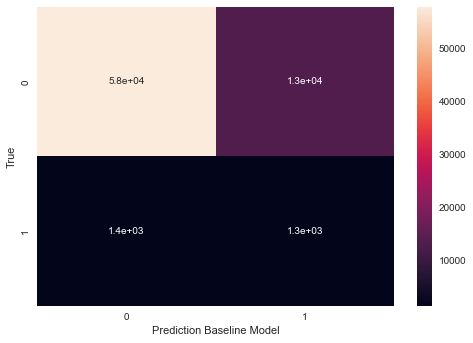

In [22]:
fbeta_test = fbeta_score(y_test, y_pred, beta=2).round(2)
auc_test = roc_auc_score(y_test, y_pred).round(2)
recall_test = recall_score(y_test, y_pred).round(2)
print("Test: f-2 score:", fbeta_test)
print("Test: Area under the ROC curve:", auc_test)
print("Test: Recall:", recall_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Prediction Baseline Model")
plt.ylabel("True");

An AUC of 0.60 and a recall of 0.22, there is definitely room for improvement with real models!

How are the predictions scattered over time?

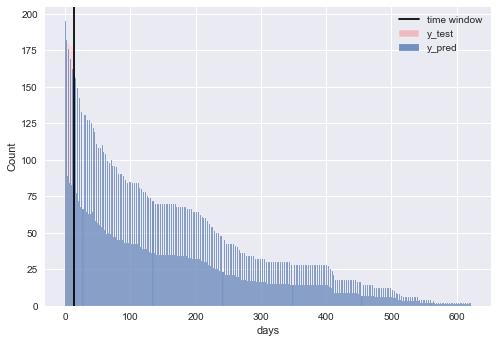

In [23]:
plotdata_pred = pd.DataFrame({"y": y_pred, "days": df_test.days_to_fail}).query("y == 1")
plotdata_test = pd.DataFrame({"y": y_test, "days": df_test.days_to_fail}).query("y == 1")
sns.histplot(data=plotdata_test, x="days", bins=time_window+1, color='r', alpha=0.2)
sns.histplot(data=plotdata_pred, x="days", bins=400)
plt.axvline(x=time_window, c='k')
plt.legend(["time window", "y_test", "y_pred"]);

We gradually classify HDDs as failing with substantial amount of HDDs classified around 100 and 50 days before failure. The day before failure we classify a lot of HDDs.

Plot ROC curve for understanding

We use probabilities of 0 or 1 since our baseline model cannot output probabilities. How does this influence the ROC curve? Will we obtain a straight line? Almost...

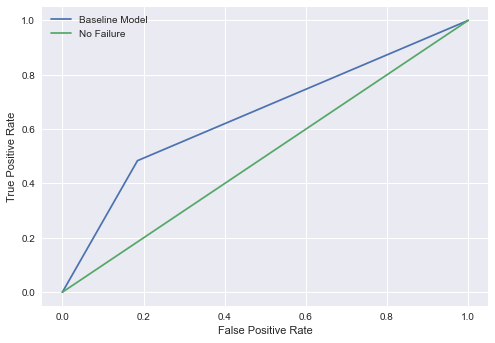

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred)
base = np.linspace(0,1,100)
sns.lineplot(fpr, tpr)
sns.lineplot(base, base)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Baseline Model", "No Failure"]);

To sum up, our baseline model seems to be able to make an educated guess on our classification problem. Nevertheless, we are optimistic, that we can beat the baseline model in the course of this project.

## Logging on MLFlow

In [25]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "thresholds": threshold,
      "time_to_fail": time_window,
      "features_above_threshold": num_above_threshold,
  }

In [26]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
mlflow.set_tag("model", "Baseline")
#logging metrics
mlflow.log_metric("train_" + "f-2 score", fbeta_train)
mlflow.log_metric("test_" + "f-2 score", fbeta_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

In [27]:
mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test_f-2 score': 0.26, 'train_f-2 score': 0.25}, params={'features_above_threshold': '2',
 'thresholds': 'smart_5_raw      0.0\n'
               'smart_183_raw    1.0\n'
               'smart_184_raw    0.0\n'
               'smart_187_raw    3.0\n'
               'Name: Threshold, dtype: float64',
 'time_to_fail': '14'}, tags={'mlflow.source.git.commit': '569d5e7b229cf1de50028af32f3ddf3535ecd4ff',
 'mlflow.source.name': '/Users/felix/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'felix',
 'model': 'Baseline',
 'running_from_jupyter': 'True'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/44/358999b635af4ea08730a072fa68f47f/artifacts', end_time=1647006246635, experiment_id='44', lifecycle_stage='active', run_id='358999b635af4ea08730a072fa68f47f', run_uuid='358999b635af4ea08730a072fa68f47f', start_time=1647006244839, status='FINISHED', user_

In [28]:
#!mlflow ui